## Prepare Notebook

In [84]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
import xarray as xr
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Censored Gamma Sample Data')

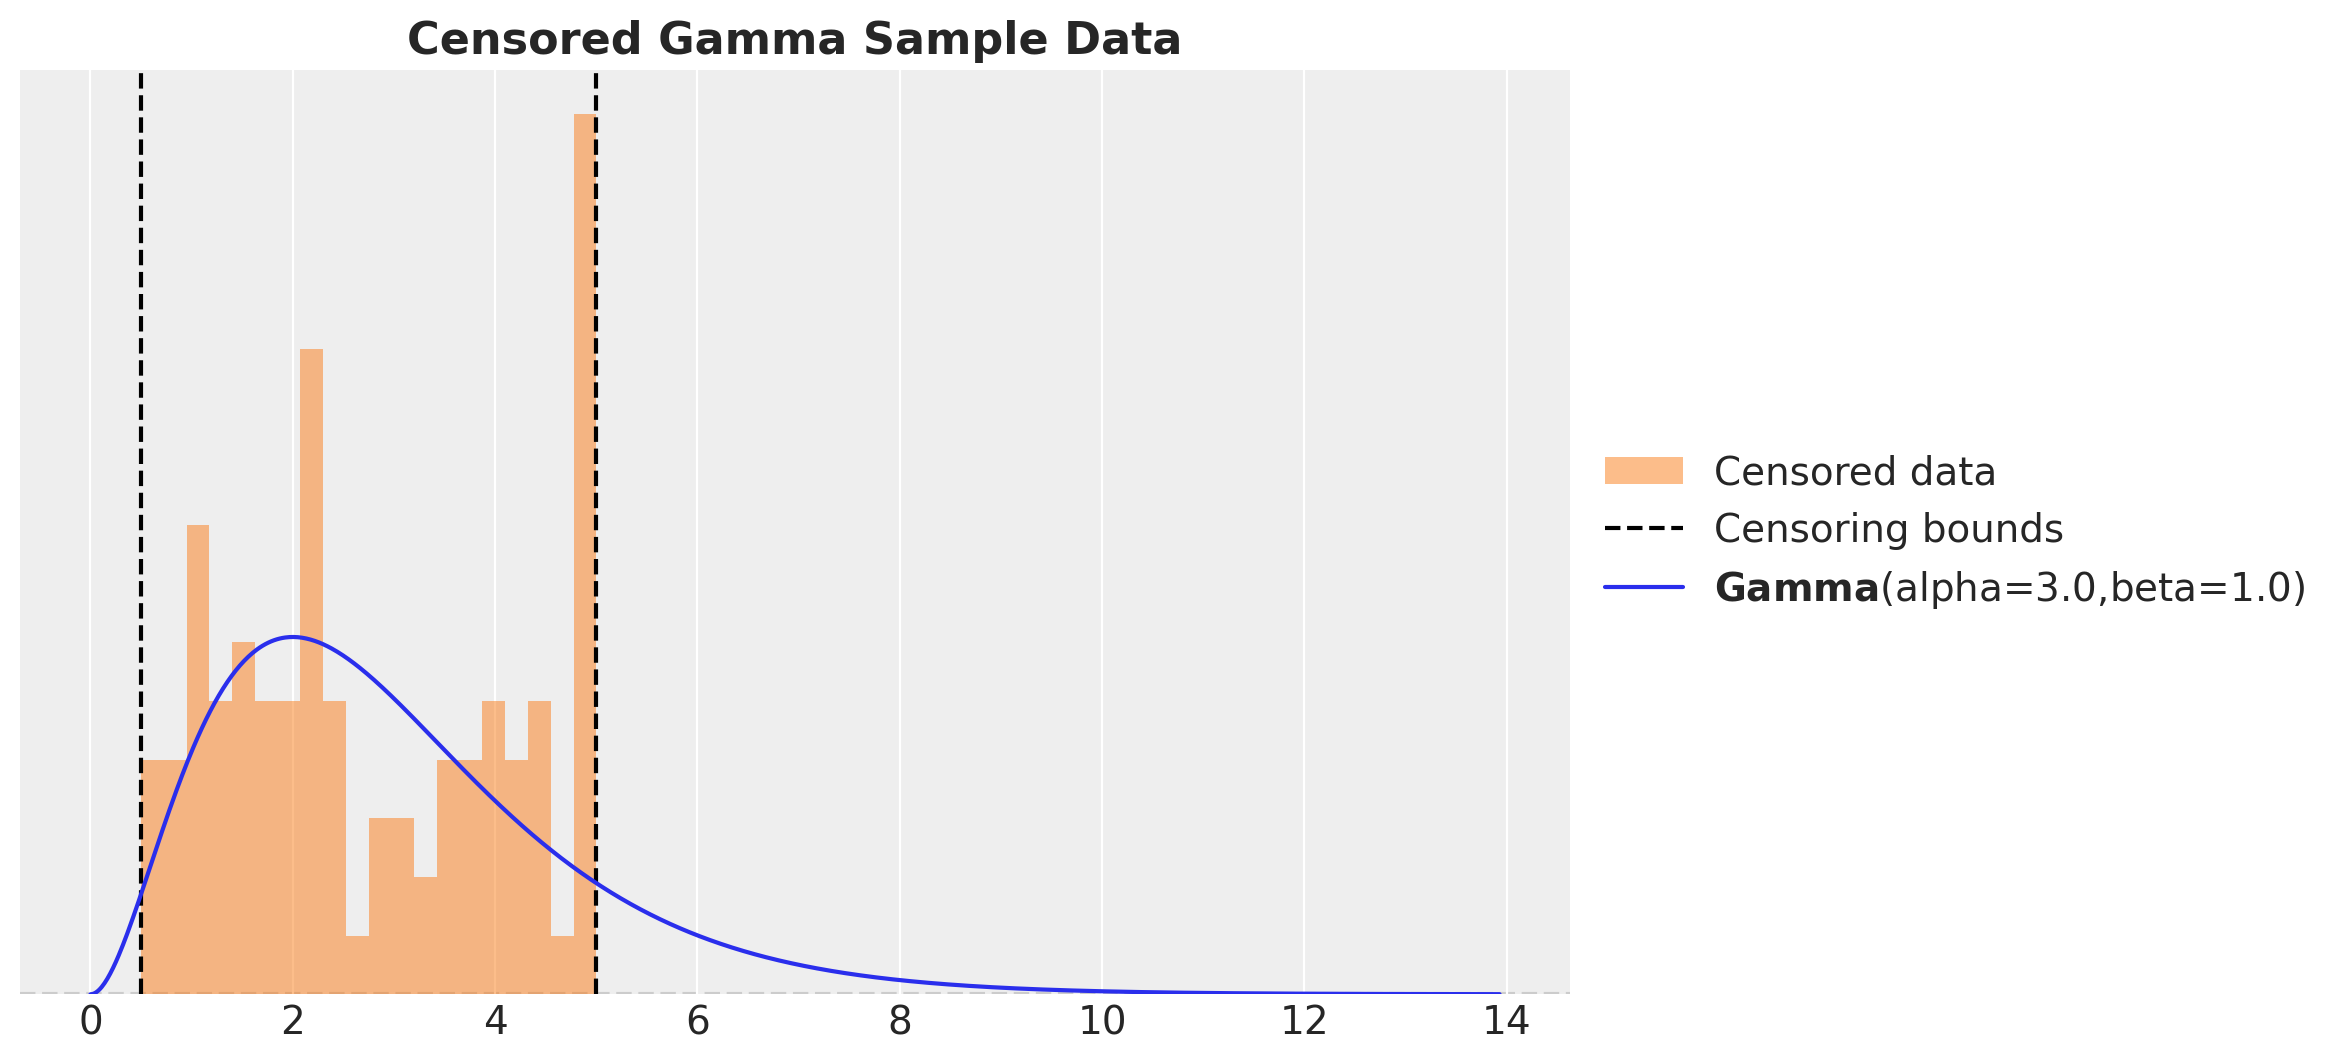

In [92]:
alpha = 3.0
beta = 1.0
lower = 0.5
upper = 5.0
n = 100


def generate_censored_gamma_samples(rng_key, alpha, beta, lower, upper, n):
    raw_samples = dist.Gamma(concentration=alpha, rate=beta).sample(rng_key, (n,))
    return jnp.clip(raw_samples, lower, upper)


rng_key, rng_subkey = random.split(rng_key)
censored_gamma_samples = generate_censored_gamma_samples(
    rng_key=rng_subkey, alpha=alpha, beta=beta, lower=lower, upper=upper, n=100
)

fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(lower, color="k", linestyle="--")
ax.axvline(upper, color="k", linestyle="--", label="Censoring bounds")
pz.Gamma(alpha=alpha, beta=beta).plot_pdf(color="C0", ax=ax)
ax.set_title("Censored Gamma Sample Data", fontsize=16, fontweight="bold")

In [44]:
def gamma_model(y=None):
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))
    numpyro.sample("y", dist.Gamma(concentration=alpha, rate=beta), obs=y)


gamma_kernel = NUTS(gamma_model)
gamma_mcmc = MCMC(gamma_kernel, num_warmup=1_000, num_samples=2_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
gamma_mcmc.run(rng_key, y=censored_gamma_samples)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [62]:
gamma_predictive = Predictive(
    model=gamma_model, posterior_samples=gamma_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
gamma_posterior_predictive = gamma_predictive(rng_subkey, y=None)

gamma_idata = az.from_numpyro(posterior=gamma_mcmc)
gamma_idata.extend(az.from_numpyro(posterior_predictive=gamma_posterior_predictive))

Text(0.5, 0.98, 'Gamma Model')

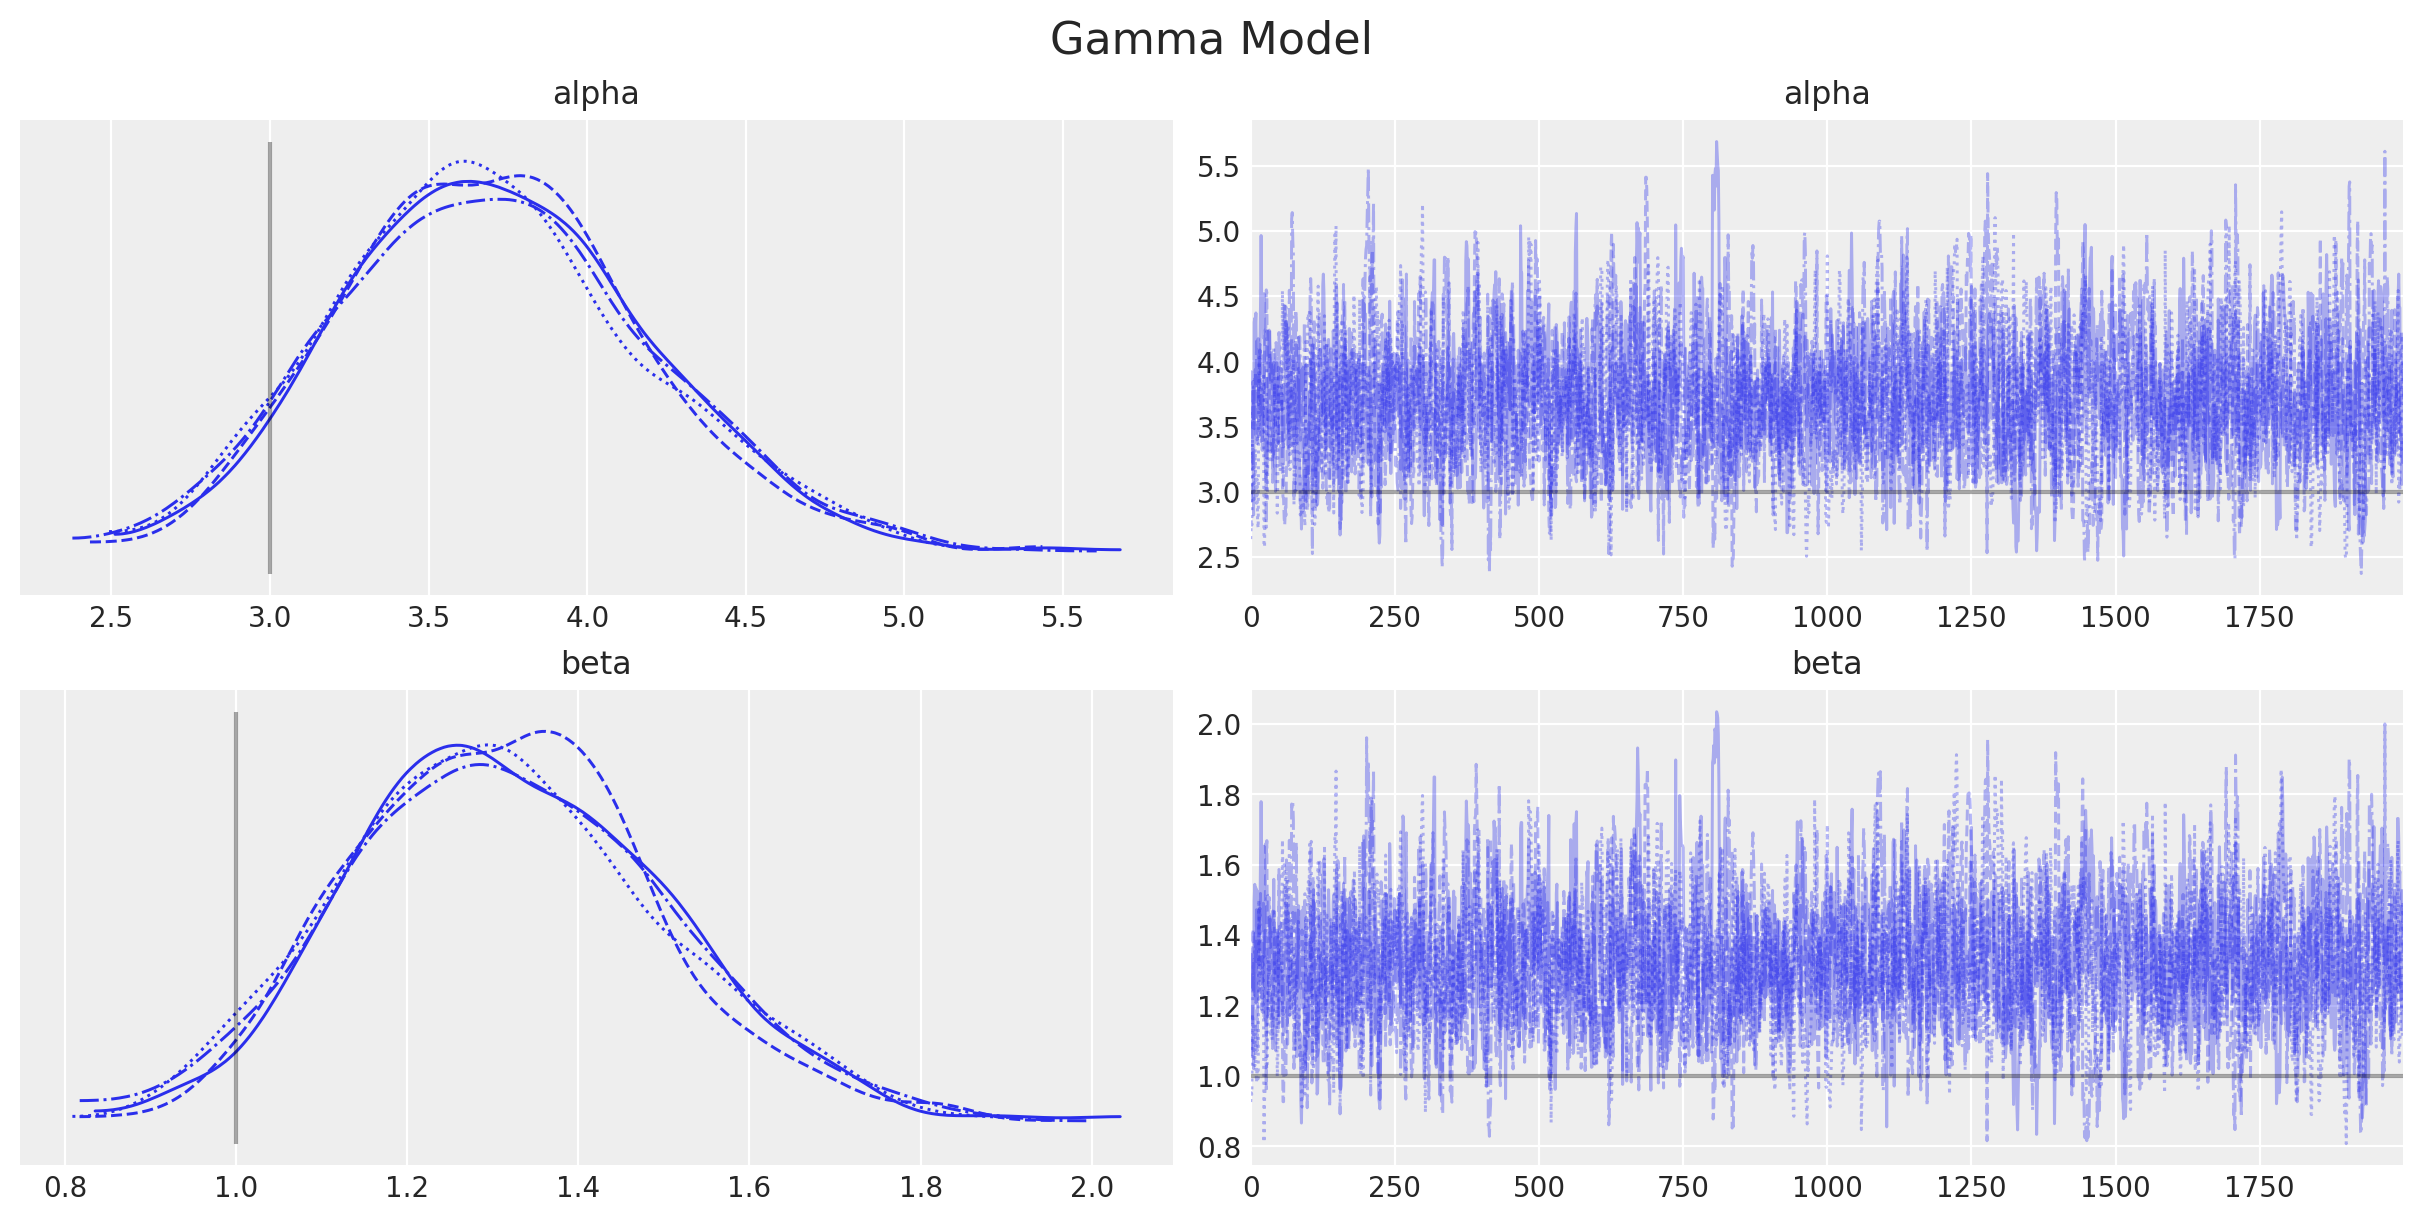

In [80]:
axes = az.plot_trace(
    data=gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, alpha),
        ("beta", {}, beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Model", fontsize=16)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

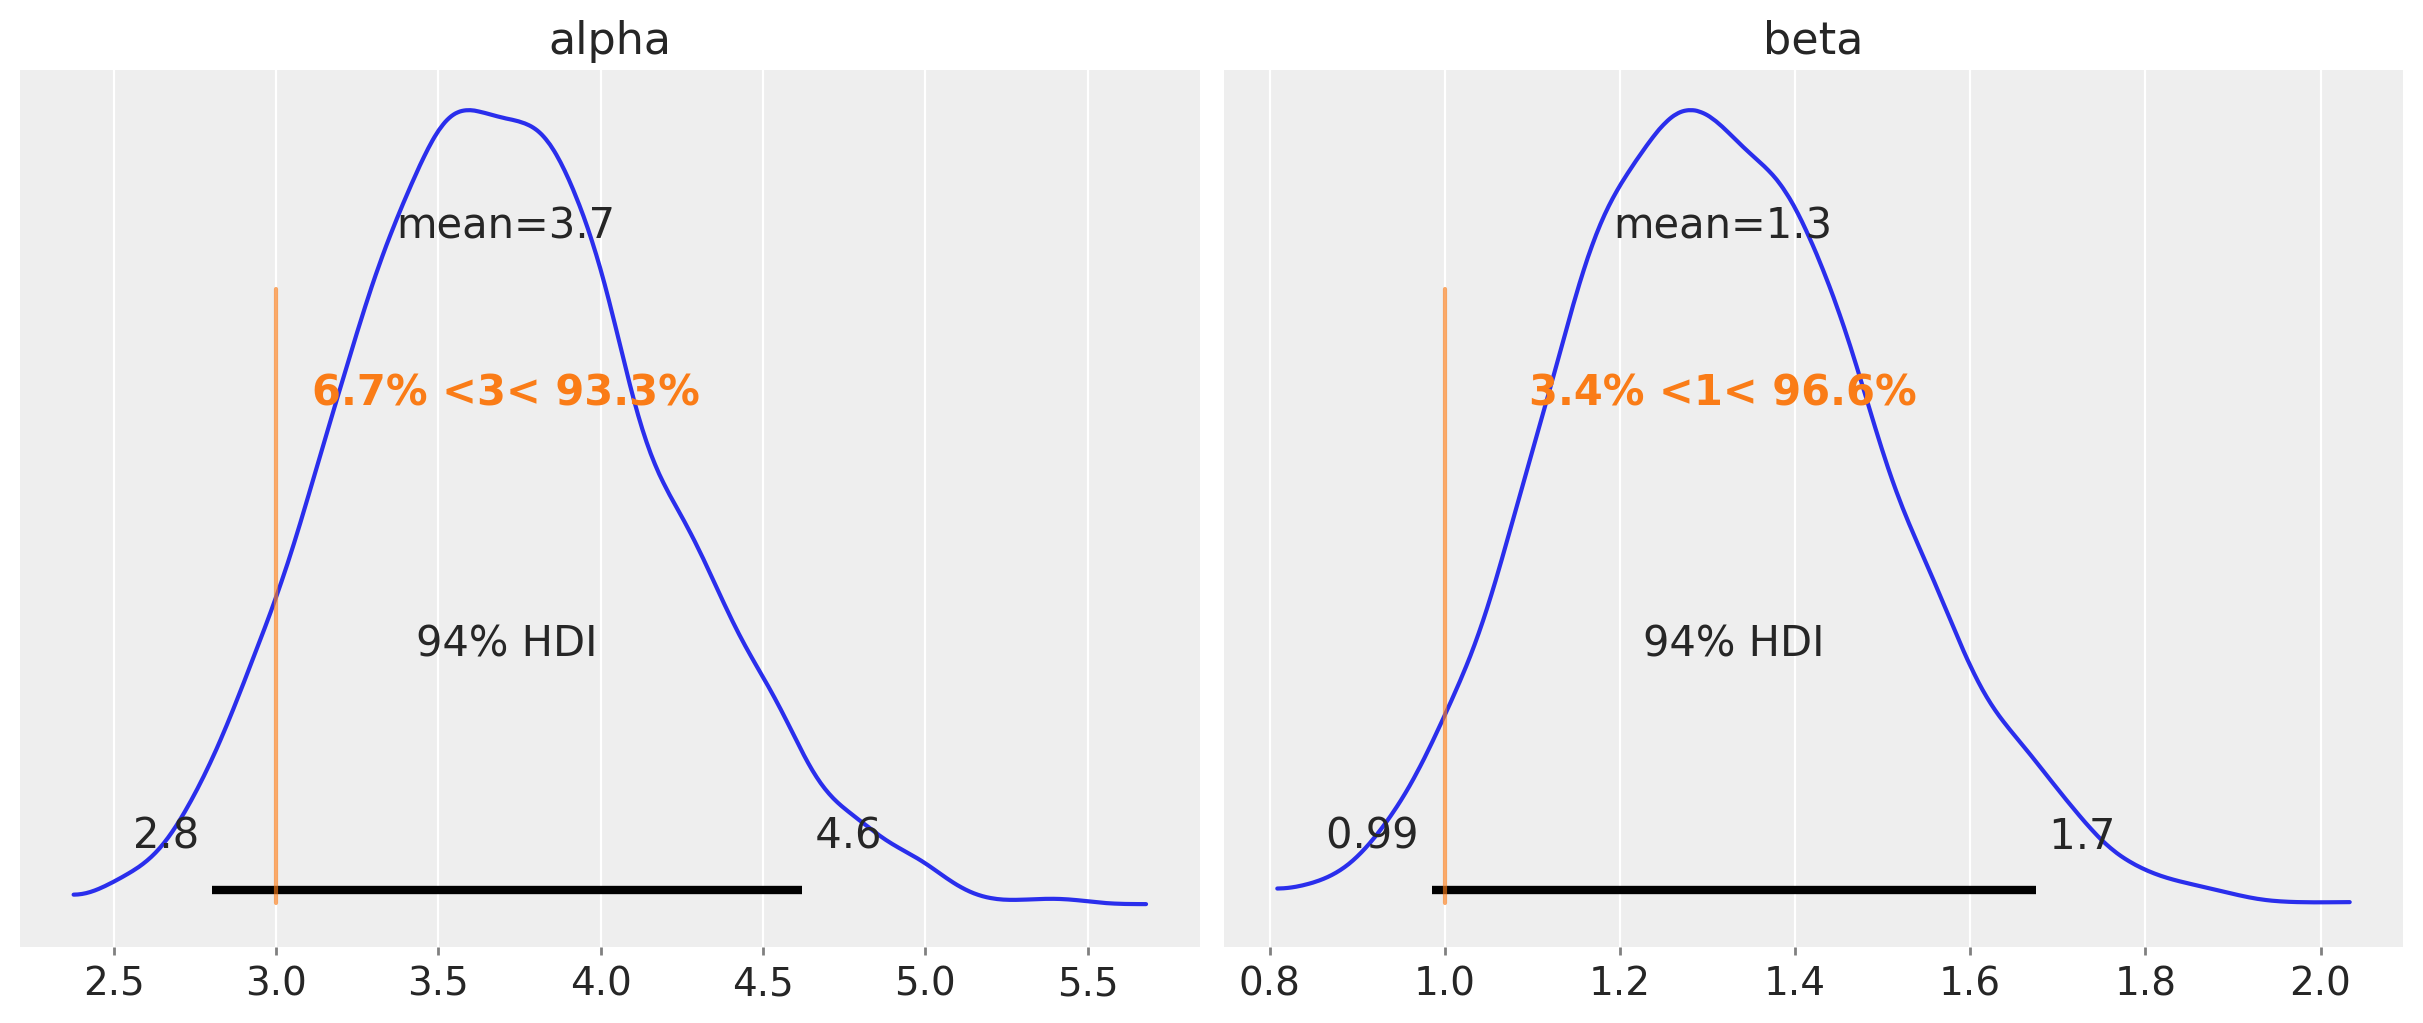

In [78]:
az.plot_posterior(
    data=gamma_idata,
    var_names=["alpha", "beta"],
    ref_val=[alpha, beta],
    round_to=2,
    figsize=(12, 5),
)

In [122]:
y = censored_gamma_samples
truncation_label = jnp.where(y == lower, -1, jnp.where(y == upper, 1, 0))

In [126]:
# https://gist.github.com/hesenp/90877ea3d5801214098fecd3b9e089bc

def censored_gamma_model(y, truncation_label):
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))

    distribution = dist.Gamma(concentration=alpha, rate=beta)

    with numpyro.mask(mask=truncation_label == -1):
        truncation_prob_lower = distribution.cdf(y)
        numpyro.sample(
            "truncated_label_lower", -dist.Bernoulli(truncation_prob_lower), obs=-1
        )

    with numpyro.mask(mask=truncation_label == 0):
        numpyro.sample("obs", distribution, obs=y)

    with numpyro.mask(mask=truncation_label == 1):
        truncation_prob_upper = 1 - distribution.cdf(y)
        numpyro.sample(
            "truncated_label_upper", dist.Bernoulli(truncation_prob_upper), obs=1
        )

In [127]:
censored_gamma_kernel = NUTS(censored_gamma_model)
censored_gamma_mcmc = MCMC(
    gamma_kernel, num_warmup=1_000, num_samples=2_000, num_chains=4
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_mcmc.run(rng_key, y=censored_gamma_samples)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Gamma Model')

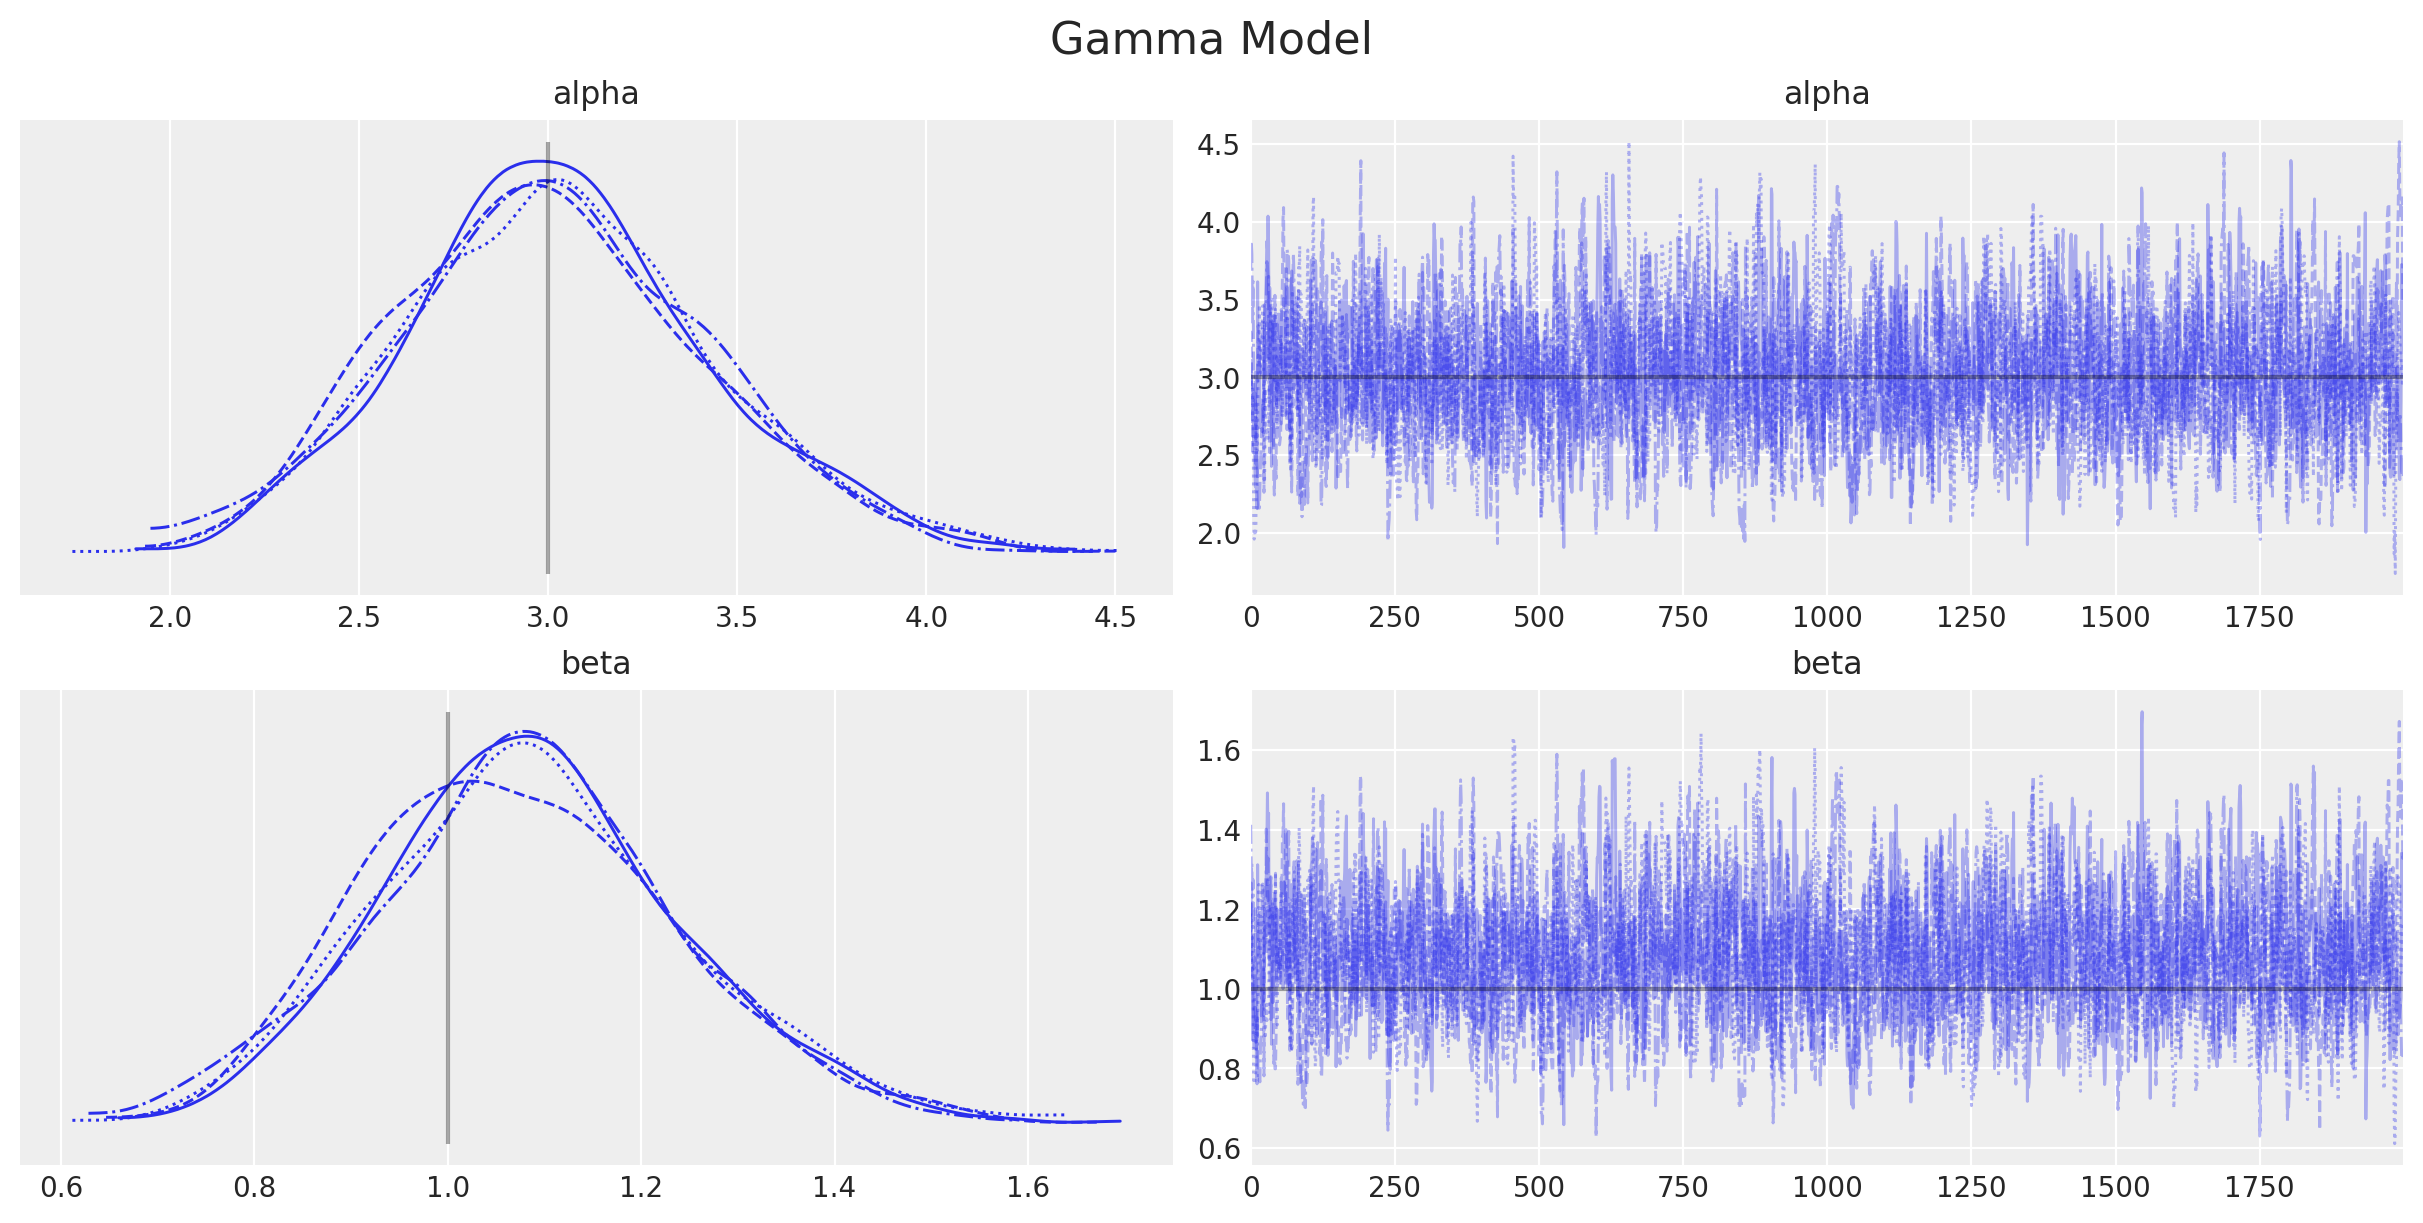

In [128]:
censored_gamma_idata = az.from_numpyro(posterior=censored_gamma_mcmc)

axes = az.plot_trace(
    data=censored_gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, alpha),
        ("beta", {}, beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Model", fontsize=16)